<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/chmntz_Lab6/Lab6/chmntz_Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6: Optimization \& Learning**
Carl **Chemnitz**

# **Abstract**
This lab discusses and implements unconstrained optimization problems such as the Gradient descent method and Newton's minimization method.

# **Set up environment**
To have access to the necessary modules you have to run this cell.

In [592]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from typing import Callable
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import axes3d

# **Introduction**
In mathematics, optimization problems are problems that requires the solution of function's maximum or minimum value. The specific function is refered to as the objective function.

There exists two types of minimizations, constrained and unconstrained minimization. The implemented methods in this lab are of the unconstrained nature. The aim is to find local solution to the general problem
$$\min_{x\in{D}}f(x).$$

# **Method**

## Gradient descent method in $R^n$

Gradient descent method is an iterative method of finding local minimum of an objective function,

\begin{equation}
x^{(k+1)}=x^{(k)}-\alpha^{(k)}\nabla f(x^{(k)}),\tag{15.4}
\end{equation}

as given as equation (15.4) in *Methods in Computational Science*. It searches for critical points by searching in the opposite direction of the gradient. In a similar manner, a maximum value can be found by searching along the direction of the gradient.

To be able to implement the gradient descent minimization, we must be able to compute the gradient numerically
$$\nabla f(x)=\begin{bmatrix}\frac{\partial f}{\partial x_1}(x)\\\vdots\\\frac{\partial f}{\partial x_n}(x)\end{bmatrix}.$$

In [593]:
def gradient(f: Callable, x: np.array) -> np.array:
    h = 1e-9 * np.eye(x.size)
    df = np.zeros(x.size)
    for i in range(x.size):
        df[i] = (f(x + h[i]) - f(x - h[i])) / (2 * 1e-9)
    return df

Gradient descent minimization can also utilize a search method to find the step legnth $\alpha^{(k)}$. Golden ratio search was chosen as the search method for this implementation. It reduces the interval by a factor of $\varphi/(1+\varphi)$ each iteration until the converge on a minimized point. If the points $s_1$ and $s_2$ do not converge, it will loop forever, therefore a limit to the amount of iterations is introduced.

In [594]:
def golden_search(f: Callable, df: np.array, x: np.array) -> float:
    s1, s2 = 0, 1
    for i in range(100):
        if abs(s2 - s1) < 1e-9: break
        s3 = (s2 - s1) / (1 + 1.618033988749)
        b = s2 - s3
        a = s1 + s3
        if f(x - a * df) < f(x - b * df):
            s2 = b
        else:
            s1 = a
    return (s1 + s2) / 2

Gradient descent method implementation is based on algorithm 15.1 in *Methods in Computational Science*.

In [595]:
def gradient_descent(f: Callable, x0: np.array) -> np.array:
    x = x0
    df = gradient(f, x0)
    while np.linalg.norm(df) > 1e-9:
        df = gradient(f, x0)
        a = golden_search(f, df, x0)
        x_new = x0 - a * df
        x0 = x_new
        x = np.vstack([x, x_new])
    return x

## Newton's method in $R^n$

Newton's minimization method find a local minimum searches in the direction of the negative Hessian inverse. It differes from gradient descent method by using Hessian matrix to calculate the search direction, called the Newton direction.

$$x^{(k+1)}=x^{(k)}-H(x^{(k)})^{-1}\nabla f(x^{(k)}).$$

The Hessian matrix is a second-order partial derivitive, square matrix,

$$H_{f_{ij}}=\frac{\partial^2f}{\partial x_i\partial x_j}.$$

In [596]:
def hessian(f: Callable, x: np.array):
    h = 1e-6 * np.eye(x.size)
    H = np.zeros([x.size, x.size])
    for i in range(x.size):
        for j in range(x.size):
            H[i, j] = (f(x+h[i]+h[j]) - f(x+h[i]-h[j]) - f(x-h[i]+h[j]) + f(x-h[i]-h[j])) / (4 * (1e-6 ** 2))
    return H

Newton's minimization method implementation is based on algorithm 15.3 in *Methods in Computational Science*.

In [597]:
def newton_min(f: Callable, x0: np.array) -> np.array:
    x = x0
    df = gradient(f, x0)
    while np.linalg.norm(df) > 1e-6:
        df = gradient(f, x0)
        hf = hessian(f, x0)
        dx = np.linalg.solve(hf, df)
        x_new = x0 - 0.5 * dx
        x0 = x_new
        x = np.vstack([x, x_new])
    return x

# **Tests \& results**

## Gradient descent method in $R^n$
We test the implementation of gradient descent method by constructing a function and choosing a guess point. We use Python's optimization library to calculate an exact solution which is used as a reference.

In [598]:
f = lambda x : np.sin(x[1])*np.exp(-(x[1]-0.1)**2-(x[0]-0.1)**2)
p_g = gradient_descent(f, np.array([0.6,0.6]))

We plot the error of each variable and the function after each step. For each step, the error of the function $f(x,y)$ should converge towards the exact solution, which it does. However, the variables do not approach each step, which is a consequence of the iterative approach.

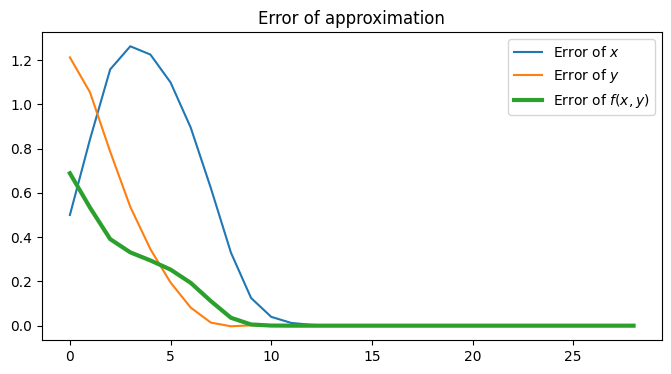

In [599]:
p_exact = sp.optimize.minimize(f, np.array([0.6,0.6]))
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot()
diff = np.zeros([len(p_g),2])
f_diff = np.zeros(len(p_g))
for i in range(len(p_g)):
    diff[i] = p_g[i,:] - p_exact.x[:]
    f_diff = f(p_g.T) - p_exact.fun
ax1.plot(range(len(diff)), diff[:,0])
ax1.plot(range(len(diff)), diff[:,1])
ax1.plot(range(len(f_diff)), f_diff, linewidth=3)
ax1.title.set_text("Error of approximation")
ax1.legend(["Error of $x$", "Error of $y$", "Error of $f(x,y)$"])
fig.show()

The solution is also plotted over the function's 3D mesh to visualize how it approaches the local solution to the optimization problem.

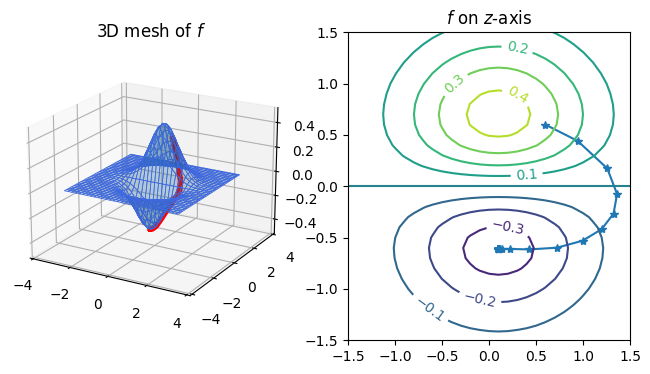

In [600]:
X, Y = np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1)
X, Y = np.meshgrid(X, Y)
Z = f([X, Y])

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, projection = '3d')
ax1.plot3D(p_g[:,0], p_g[:,1], f(p_g.T), '-', linewidth=4, c='r', alpha = 1)
ax1.set(xlim=(-4, 4), ylim=(-4, 4), zlim=(-0.5, 0.5))
ax1.view_init(elev=20, azim=300)
ax1.plot_surface(X, Y, Z, edgecolor='royalblue',
                 linewidth = 0, lw = 0.5, alpha = 0.3,
                 rstride=2, cstride=2, zorder = 100)
ax1.title.set_text("3D mesh of $f$")
ax2 = fig.add_subplot(122)
ax2.plot(p_g[:,0], p_g[:,1], '*-')
cs = ax2.contour(X, Y, Z)
ax2.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
ax2.clabel(cs, inline=True, fontsize=10)
ax2.title.set_text("$f$ on $z$-axis")

fig.show()

## Newton's minimization method in $R^n$
We construct another function $f(x,y)$ and compute the exact and the approximate solution.


In [601]:
f = lambda x : 0.3 * (x[0]**3 + x[1]**2 - x[0])
p_n = newton_min(f, np.array([2, 3.4]))

Similar to gradient descent method, the function $f(x,y)$ error is expected to decrease each iteration.

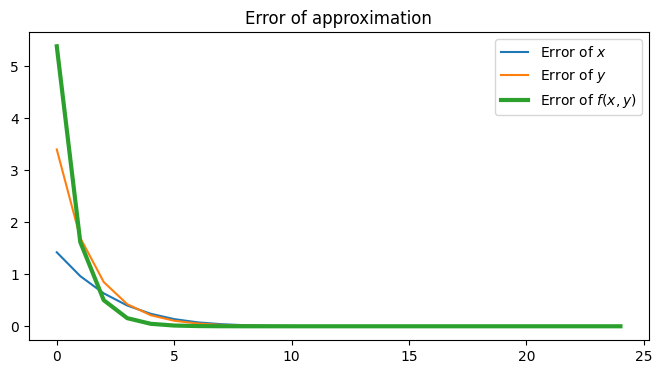

In [602]:
p_exact = sp.optimize.minimize(f, np.array([2, 3.4]))
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot()
diff = np.zeros([len(p_n),2])
f_diff = np.zeros(len(p_n))
for i in range(len(p_n)):
    diff[i] = p_n[i,:] - p_exact.x
    f_diff = f(p_n.T) - p_exact.fun
ax1.plot(range(len(diff)), diff[:,0])
ax1.plot(range(len(diff)), diff[:,1])
ax1.plot(range(len(f_diff)), f_diff, linewidth=3)
ax1.title.set_text("Error of approximation")
ax1.legend(["Error of $x$", "Error of $y$", "Error of $f(x,y)$"])
fig.show()

We visualize the solution over the function mesh.

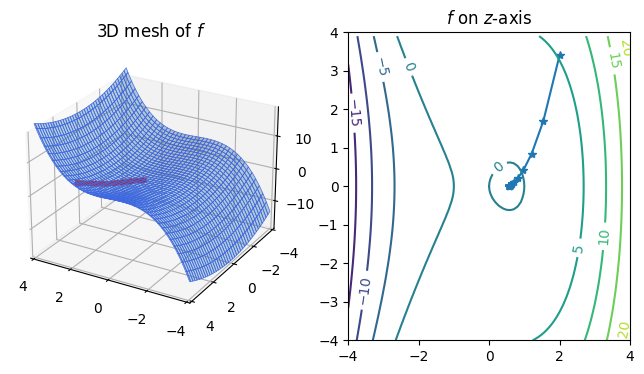

In [603]:
X, Y = np.arange(-4, 4, 0.1), np.arange(-4, 4, 0.1)
X, Y = np.meshgrid(X, Y)
Z = f([X, Y])

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, projection = '3d')
ax1.plot3D(p_n[:,0], p_n[:,1], f(p_n.T), '-', linewidth=4, c='r', alpha = 1)
ax1.set(xlim=(-4, 4), ylim=(-4, 4), zlim=(-18, 18))
ax1.view_init(elev=25, azim=120)
#ax1.view_init(elev=25, azim=300)
ax1.plot_surface(X, Y, Z, edgecolor='royalblue',
                 linewidth = 0, lw = 0.5, alpha = 0.3,
                 rstride=2, cstride=2, zorder = 100)
ax1.title.set_text("3D mesh of $f$")
ax2 = fig.add_subplot(122)
ax2.plot(p_n[:,0], p_n[:,1], '*-')
cs = ax2.contour(X, Y, Z)
ax2.set(xlim=(-4, 4), ylim=(-4, 4))
ax2.clabel(cs, inline=True, fontsize=10)
ax2.title.set_text("$f$ on $z$-axis")

fig.show()

# **Discussion**
When computing the Hessian matrix, $h$ could not be too small as the $h^2$ would become too small for the computer to handle reliably. Thus, a larger $h$ was chosen for Newton's method than for gradient descent.

According this MIT [paper](https://ocw.mit.edu/courses/15-084j-nonlinear-programming-spring-2004/83159d56de04a7e7dc94d0348fa4ccda_lec3_newton_mthd.pdfz), using the Hessian to determine the search direction will not guarantee that $f(x^{(k+1)})\leq f(x^{(k)})$. I used the first function that was used to test the gradient descent method will result the in the maximal value when using Newton's minimization method. Hence, I do not believe my implementation is incorrect but rather that the model is limited or naive. I am unsure of how to modify the implementation to guarantee minimum value.